In [1]:
import os
import sys
sys.path.insert(0, '/tf')

gpu_num = "1" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, RIS

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, channel_capacity, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement


In [2]:
# Load the scene
scene = load_scene("../test_scenes/hallway/hallway.xml")

print(f'size:{scene.size}' )
print(f'center:{scene.center}')


scene.remove("tx")
scene.remove("rx")
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,0,2.5])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[3,0,2.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

# Introduce RIS
ris_array = PlanarArray(num_rows=4,
                             num_cols=12,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")

ris = RIS(name="ris", position = [-5,0,2.5],ris_array=ris_array,ris_phases=None)

scene.frequency = 2.4e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Assign Radio material
scene.get("elm__3").radio_material.scattering_coefficient = 0.5

# Define the size of the grid
cell_size = 1 # meter

# Define the range of x and y values
x = np.arange(-5, 5, cell_size)  
y = np.arange(-10, 10, cell_size)

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Receiver locations to be swept
Rx_locations = [[X[i, j], Y[i, j], 2.5] for i in range(X.shape[0]) for j in range(X.shape[1])]
Tx_location = scene.transmitters["tx"].position.numpy().tolist()

size:[10.02     20.04      5.020002]
center:[0.        0.        2.5000002]


In [3]:
subcarrier_spacing = 312.5e3
fft_size = 64
noise_floor = np.exp(0.1*(-174 + 10*np.log10(subcarrier_spacing) - 30 + 5))

frequencies = scene.frequency + subcarrier_frequencies(fft_size, subcarrier_spacing)

paths = scene.compute_paths(max_depth=1,
                                num_samples=10e6, reflection=True,scattering=True)  # Number of rays shot into directions defined
                                                # by a Fibonacci sphere, too few rays can
                                                # lead to missing paths
paths.normalize_delays = False
a, tau = paths.cir(reflection=True,scattering=True)
h_freq_env = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss

paths.normalize_delays = False
a, tau = paths.cir(reflection=False,scattering=False)
h_freq_los = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss
T = tf.constant([[1,0],[0,1]],dtype=tf.complex64)
ris.element_transfer_matrix = T
h_freq_ris,h1,h2 = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


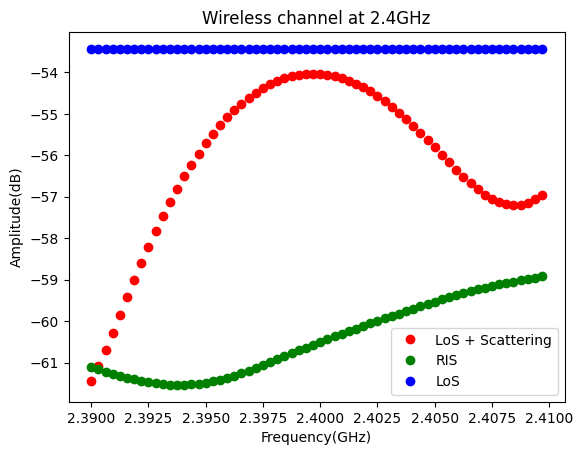

In [4]:
a = h_freq_env[0,0,0,0,0,0,:].numpy()
b = h_freq_ris[0,0,0,0,0,0,:].numpy()
c = h_freq_los[0,0,0,0,0,0,:].numpy()

plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro',label='LoS + Scattering')
plt.plot(frequencies/1e9,20*np.log10(b),'go',label = 'RIS')
plt.plot(frequencies/1e9,20*np.log10(c),'bo',label = 'LoS')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Amplitude(dB)")
plt.title("Wireless channel at 2.4GHz")
plt.legend()


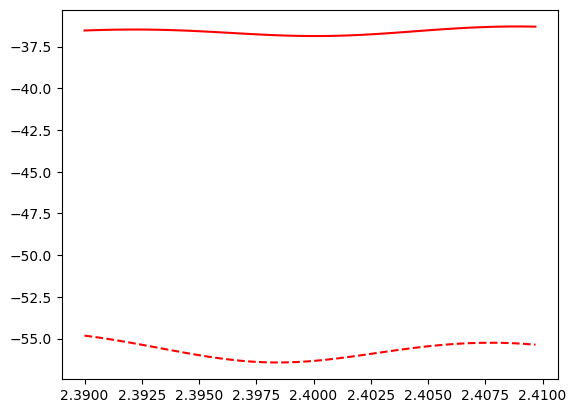

In [5]:

d = h1[0,0,0,0,0,0,:].numpy()
e = h2[0,0,0,0,0,0,:].numpy()



plt.plot(frequencies/1e9,20*np.log10(d),'r-')
plt.plot(frequencies/1e9,20*np.log10(e),'r--')

In [6]:
print(scene.receivers.items())

dict_items([('rx', <sionna.rt.receiver.Receiver object at 0x7ff1284c7070>)])


In [19]:
for tx_label,_ in scene.transmitters.items():
            scene.remove(tx_label)

In [20]:
print(scene.transmitters)

{}
